In [ ]:
import pandas as pd
import numpy as np
import json
import pathlib

# Read in the runs data. This contains runs from all models, as well all human baseline runs
runs_file = pathlib.Path("data/external/all_runs.jsonl")
df = pd.DataFrame(
    [json.loads(line) for line in runs_file.read_text().strip().splitlines()]
)

df_agent_runs = df[df["alias"] != "human"]
df_human_baselines = df[df["alias"] == "human"]

print(f"Number of agent runs: {len(df_agent_runs)}")
print(f"Number of human runs: {len(df_human_baselines)}")

df.describe()

Number of agent runs: 18171
Number of human runs: 793


,score_cont,score_binarized,human_minutes,human_score,generation_cost,human_cost,time_limit,started_at,completed_at,equal_task_weight,invsqrt_task_weight
count,18964.000000,18964.000000,18964.000000,18964.000000,18171.000000,18964.000000,11354.000000,1.135400e+04,1.135400e+04,18964.000000,18964.000000
mean,0.570852,0.551202,88.145810,1.021730,6.255015,210.976997,33485.643826,1.651046e+12,1.651048e+12,0.000791,0.000791
std,0.485319,0.497385,187.954658,0.336799,21.024168,449.869474,9176.178474,3.753785e+11,3.753752e+11,0.000494,0.000821
min,0.000000,0.000000,0.019920,0.750000,0.000000,0.047679,0.000000,0.000000e+00,0.000000e+00,0.000084,0.000101
25%,0.000000,0.000000,0.094837,1.000000,0.000950,0.226991,36000.000000,1.734697e+12,1.734700e+12,0.000735,0.000397
50%,1.000000,1.000000,8.678000,1.000000,0.049665,20.770793,36000.000000,1.735885e+12,1.735885e+12,0.000735,0.000623
75%,1.000000,1.000000,47.000000,1.000000,1.705735,112.494500,36000.000000,1.737149e+12,1.737151e+12,0.000735,0.000881
max,1.000000,1.000000,1111.887000,5.229000,179.606865,2661.301534,36000.000000,1.742000e+12,1.742018e+12,0.006579,0.014208


In [2]:
# Calculate task information
df_tasks = df.groupby("task_id", as_index=True).agg(
    num_runs=("run_id", "nunique"),
    num_human_runs=("alias", lambda x: (x == "human").sum()),
    human_score=("human_score", "first"),
    human_minutes=("human_minutes", "first"),
)
df_tasks["family"] = df_tasks.index.str.rsplit("/", n=1).str[0]

df_tasks["avg_model_score_on_task"] = df_agent_runs.groupby("task_id").apply(
    lambda x: np.average(x["score_binarized"], weights=x["invsqrt_task_weight"])
)

# Check out a random sample of the tasks
df_tasks.sample(5)

/tmp/ipykernel_66513/1555566478.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_tasks["avg_model_score_on_task"] = df_agent_runs.groupby("task_id").apply(


,num_runs,num_human_runs,human_score,human_minutes,family,avg_model_score_on_task
task_id,,,,,,
code_completion/git_status,117,3,1.0,0.069457,code_completion,0.919419
alert_triage/alert_triage_8,118,4,1.0,0.070518,alert_triage,0.980326
spn_cryptanalysis/3-stage-spn,90,2,1.0,180.000000,spn_cryptanalysis,0.000000
hypothesis_testing/mystery_function_5,94,4,1.0,27.769000,hypothesis_testing,0.300662
image_labeling/layered_squares,91,3,1.0,87.306000,image_labeling,0.102278


In [3]:
df_tasks.loc["ai_rd_restricted_mlm/main"]

num_runs                                    107
num_human_runs                               11
human_score                               1.586
human_minutes                           479.196
family                     ai_rd_restricted_mlm
avg_model_score_on_task                0.018755
Name: ai_rd_restricted_mlm/main, dtype: object

In [4]:
# Read in release dates from yaml
import yaml

with open("data/external/release_dates.yaml", "r") as f:
    s_release_dates = pd.Series(
        yaml.safe_load(f)["date"], name="release_dates"
    ).sort_values()

s_release_dates

GPT-2                           2019-02-14
davinci-002 (GPT-3)             2020-05-28
gpt-3.5-turbo-instruct          2022-03-15
GPT-4 0314                      2023-03-14
GPT-4 0613                      2023-06-13
GPT-4 1106                      2023-11-06
GPT-4 0125                      2024-01-25
Claude 3 Sonnet                 2024-03-04
Claude 3 Opus                   2024-03-04
GPT-4 Turbo                     2024-04-09
GPT-4o                          2024-05-13
Claude 3.5 Sonnet (old)         2024-06-20
Claude 3.5 Sonnet (Old)         2024-06-20
GPT-4o mini                     2024-07-18
o1-preview (elicited)           2024-09-12
o1-preview                      2024-09-12
Claude 3.5 Sonnet (retry 8x)    2024-10-22
Claude 3.5 Sonnet               2024-10-22
Claude 3.5 Sonnet (New)         2024-10-22
o1                              2024-12-05
Claude 3.7 Sonnet               2025-02-24
Name: release_dates, dtype: object

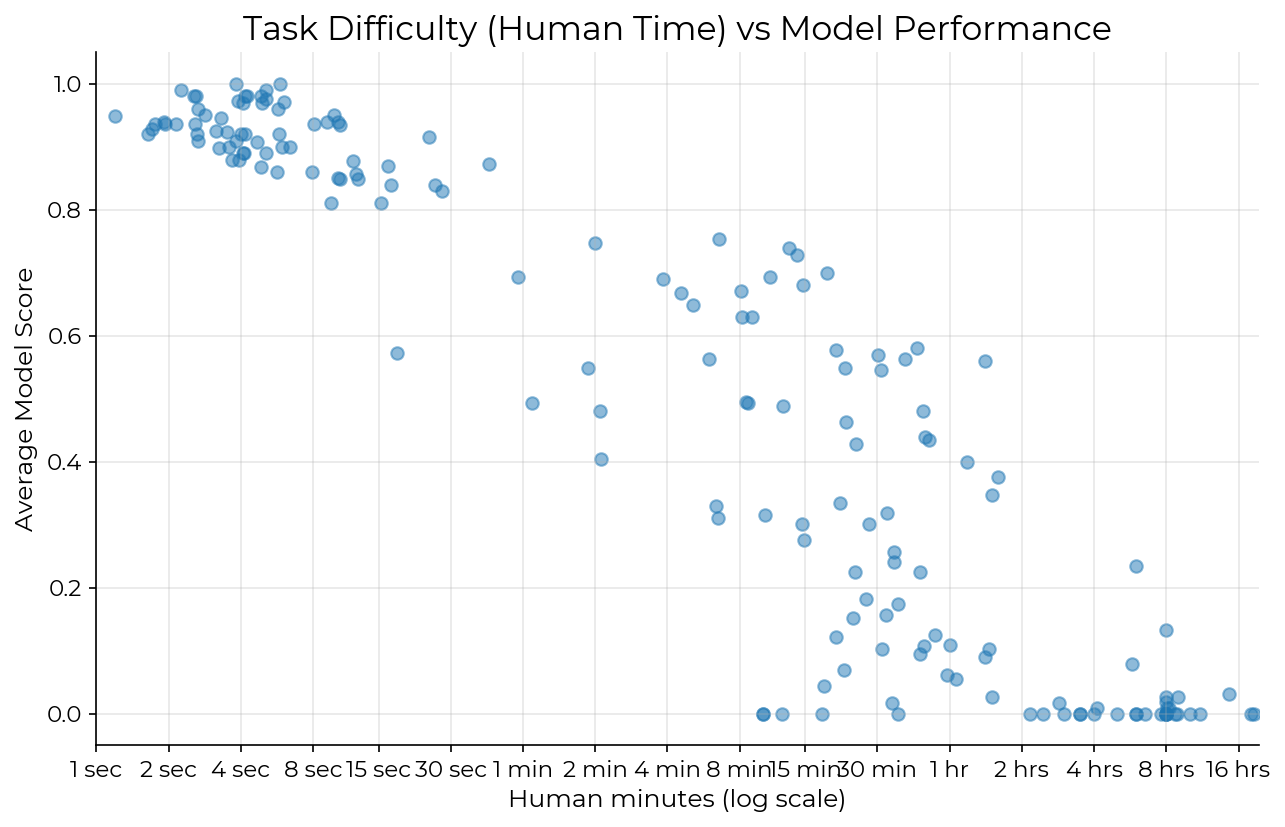

In [5]:
# Scatterplot of log(human_minutes) vs average model score
# Human time is the geometric mean of human baseliner time
import matplotlib.pyplot as plt
from src.utils.plots import log_x_axis

fig, ax = plt.subplots(figsize=(10, 6))

x = df_tasks["human_minutes"]
y = df_tasks["avg_model_score_on_task"]

plt.scatter(x, y, alpha=0.5)

ax.set_xlim(left=1 / 60)
log_x_axis(ax)

ax.set_xlabel("Human minutes (log scale)")
ax.set_ylabel("Average Model Score")
ax.set_title("Task Difficulty (Human Time) vs Model Performance")

plt.grid(True, alpha=0.3)
plt.show()

Now let's graph model performance over time. Our report puts model "horizon length" on the y axis, but we can much more simply just get the scores of each model. To get horizon lengths for each model as well as confidence intervals, `dvc pull` then use `data/wrangled/logistic_regression_{hyperparams}.csv`.

/tmp/ipykernel_66513/905014236.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_model_score = df_agent_runs.groupby("alias", as_index=True).apply(


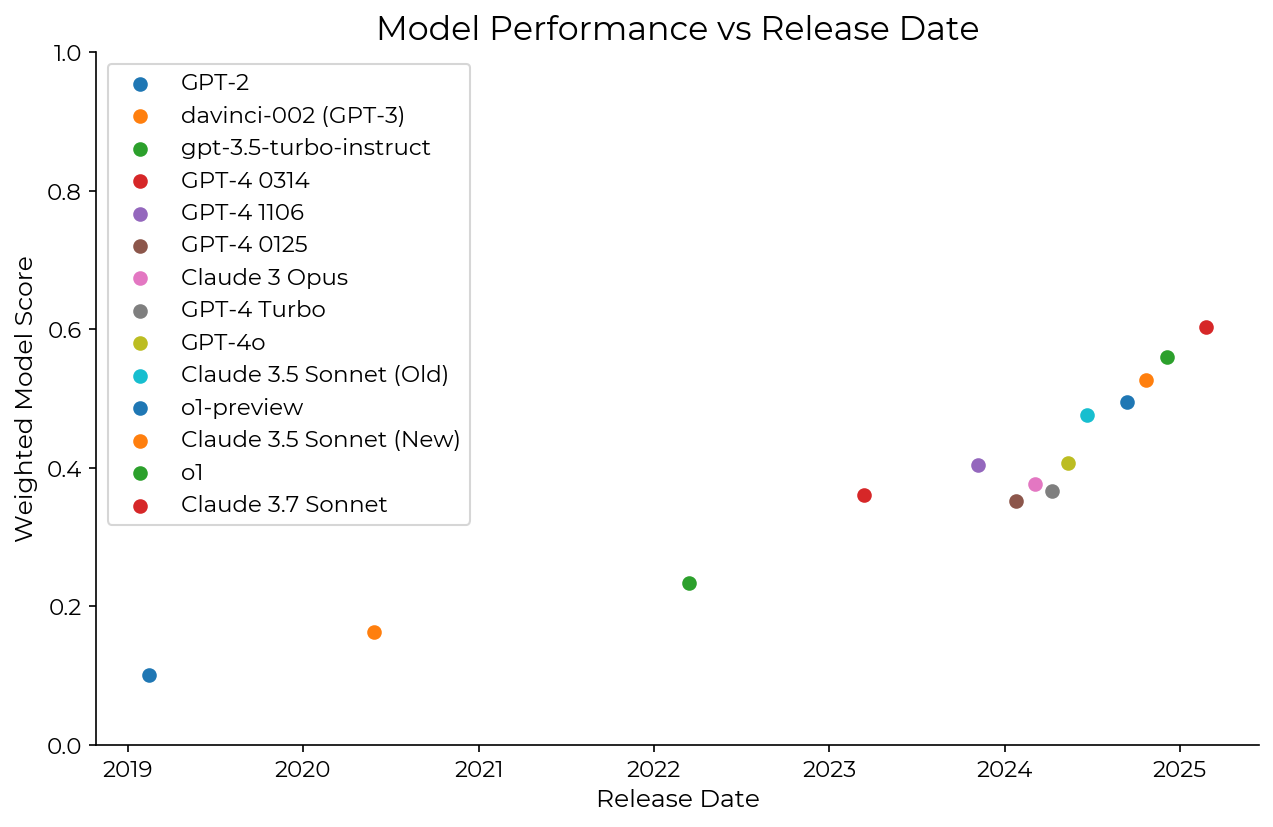

In [6]:
weighted_model_score = df_agent_runs.groupby("alias", as_index=True).apply(
    lambda x: np.average(x["score_binarized"], weights=x["invsqrt_task_weight"])
)

# Merge weighted scores with release dates and sort by date
df_model_scores = (
    pd.DataFrame({"score": weighted_model_score, "release_date": s_release_dates})
    .dropna()
    .sort_values("release_date")
)


# Scatterplot of weighted model score vs release date
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel("Release Date")
ax.set_ylabel("Weighted Model Score")
ax.set_title("Model Performance vs Release Date")

for date, score, model in zip(
    df_model_scores["release_date"], df_model_scores["score"], df_model_scores.index
):
    ax.scatter(date, score, label=model)
ax.legend(loc="upper left")
ax.set_ylim(0, 1)
plt.show()